In [ ]:
# Notebook 03: Модели с регуляризацией (Ridge и Lasso)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Для регрессии и регуляризации
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Для статистического анализа
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

In [ ]:
# 1. ЗАГРУЗКА ДАННЫХ И ПОДГОТОВКА

In [2]:
# Загрузка данных
df = pd.read_excel('../data/Dataset-region-52.xlsx')

# Финальный набор переменных после устранения мультиколлинеарности
y = df['potras'].copy()
X_all_vars = ['doxodsn', 'natdox', 'nalog', 'ssber', 'kvzv', 'dhpens']
X_all = df[X_all_vars].copy()

print(f"\nРазмер выборки: n = {len(y)}")
print(f"Все переменные ({len(X_all_vars)}): {X_all_vars}")

# Переменные из лучшей модели Задания 3 (Backward Elimination)
best_vars_task3 = ['doxodsn', 'natdox', 'nalog', 'ssber']
X_best_task3 = df[best_vars_task3].copy()

print(f"Переменные из лучшей модели Задания 3 ({len(best_vars_task3)}): {best_vars_task3}")


Размер выборки: n = 2605
Все переменные (6): ['doxodsn', 'natdox', 'nalog', 'ssber', 'kvzv', 'dhpens']
Переменные из лучшей модели Задания 3 (4): ['doxodsn', 'natdox', 'nalog', 'ssber']


In [3]:
# 2. БАЗОВАЯ МОДЕЛЬ ИЗ ЗАДАНИЯ 3 (ДЛЯ СРАВНЕНИЯ)

In [3]:
# OLS модель с лучшими переменными
X_baseline = sm.add_constant(X_best_task3)
model_baseline = sm.OLS(y, X_baseline).fit()

# Метрики
y_pred_baseline = model_baseline.fittedvalues
mse_baseline = mean_squared_error(y, y_pred_baseline)
r2_baseline = r2_score(y, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)

# ESS (Explained Sum of Squares)
y_mean = y.mean()
ess_baseline = np.sum((y_pred_baseline - y_mean) ** 2)

# TSS (Total Sum of Squares)
tss = np.sum((y - y_mean) ** 2)

# RSS (Residual Sum of Squares)
rss_baseline = np.sum((y - y_pred_baseline) ** 2)

print(f"\nБазовая модель (OLS Backward Elimination):")
print(f"  R² = {r2_baseline:.6f}")
print(f"  MSE = {mse_baseline:.2f}")
print(f"  RMSE = {rmse_baseline:.2f}")
print(f"  ESS = {ess_baseline:.2f}")
print(f"  RSS = {rss_baseline:.2f}")
print(f"  TSS = {tss:.2f}")
print(f"  Переменных: {len(best_vars_task3)}")


Базовая модель (OLS Backward Elimination):
  R² = 0.556100
  MSE = 3392763791.63
  RMSE = 58247.44
  ESS = 11072096598815.55
  RSS = 8838149677200.34
  TSS = 19910246276015.88
  Переменных: 4


In [ ]:
# 3. СТАНДАРТИЗАЦИЯ ДАННЫХ

In [4]:
print("""
Почему нужна стандартизация для Ridge и Lasso?

Ridge и Lasso накладывают штраф на величину коэффициентов.
Если переменные имеют разный масштаб, штраф будет несправедлив:
  - Переменная с большим масштабом получит большой штраф
  - Переменная с маленьким масштабом получит маленький штраф

Стандартизация (z-score): X_scaled = (X - mean) / std
  - Приводит все переменные к единому масштабу (среднее=0, std=1)
  - Делает штраф справедливым для всех переменных
""")

# Стандартизация
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)
X_best_scaled = scaler.fit_transform(X_best_task3)

print(f"\nИсходные данные (до стандартизации):")
print(X_all.describe().loc[['mean', 'std']].round(2))

print(f"\nСтандартизованные данные (после):")
X_all_scaled_df = pd.DataFrame(X_all_scaled, columns=X_all_vars)
print(X_all_scaled_df.describe().loc[['mean', 'std']].round(6))

print("\nВсе переменные теперь имеют mean ≈ 0 и std ≈ 1")


Почему нужна стандартизация для Ridge и Lasso?

Ridge и Lasso накладывают штраф на величину коэффициентов.
Если переменные имеют разный масштаб, штраф будет несправедлив:
  - Переменная с большим масштабом получит большой штраф
  - Переменная с маленьким масштабом получит маленький штраф

Стандартизация (z-score): X_scaled = (X - mean) / std
  - Приводит все переменные к единому масштабу (среднее=0, std=1)
  - Делает штраф справедливым для всех переменных


Исходные данные (до стандартизации):
        doxodsn    natdox     nalog     ssber     kvzv  dhpens
mean  128985.39   8898.57   8886.83  11102.02  1107.73    0.36
std    82008.21  11449.29  11593.63  22630.71  2276.38    0.48

Стандартизованные данные (после):
       doxodsn    natdox     nalog     ssber      kvzv    dhpens
mean  0.000000  0.000000 -0.000000  0.000000 -0.000000  0.000000
std   1.000192  1.000192  1.000192  1.000192  1.000192  1.000192

Все переменные теперь имеют mean ≈ 0 и std ≈ 1


In [ ]:
# 4. RIDGE-РЕГРЕССИЯ С КРОСС-ВАЛИДАЦИЕЙ

In [5]:
print("""
Ridge-регрессия добавляет L2-штраф к функции потерь:
  Loss = MSE + α × Σ(βᵢ²)
  
где α (lambda) - параметр регуляризации:
  - α = 0: обычная OLS (без регуляризации)
  - α → ∞: все коэффициенты → 0
  
Ridge УМЕНЬШАЕТ коэффициенты, но НЕ обнуляет их.
Все переменные остаются в модели.
""")

# Диапазон значений alpha для поиска
alphas = np.logspace(-3, 5, 100)  # от 0.001 до 100,000

# Кросс-валидация для выбора оптимального alpha
ridge_cv = RidgeCV(alphas=alphas, cv=10, scoring='neg_mean_squared_error')
ridge_cv.fit(X_all_scaled, y)

best_alpha_ridge = ridge_cv.alpha_

print(f"\nКросс-валидация (10-fold):")
print(f"  Протестировано значений α: {len(alphas)}")
print(f"  Диапазон α: [{alphas.min():.3f}, {alphas.max():.0f}]")
print(f"  Оптимальное α (Ridge): {best_alpha_ridge:.4f}")

# Обучение Ridge с оптимальным alpha
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_all_scaled, y)

# Предсказания
y_pred_ridge = ridge_model.predict(X_all_scaled)

# Метрики
mse_ridge = mean_squared_error(y, y_pred_ridge)
r2_ridge = r2_score(y, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

# ESS и RSS
ess_ridge = np.sum((y_pred_ridge - y_mean) ** 2)
rss_ridge = np.sum((y - y_pred_ridge) ** 2)

print(f"\nМетрики Ridge-регрессии (α = {best_alpha_ridge:.4f}):")
print(f"  R² = {r2_ridge:.6f}")
print(f"  MSE = {mse_ridge:.2f}")
print(f"  RMSE = {rmse_ridge:.2f}")
print(f"  ESS = {ess_ridge:.2f}")
print(f"  RSS = {rss_ridge:.2f}")

# Коэффициенты Ridge
ridge_coefs = pd.DataFrame({
    'Переменная': X_all_vars,
    'Коэффициент (Ridge)': ridge_model.coef_
}).sort_values('Коэффициент (Ridge)', key=abs, ascending=False)

print(f"\nКоэффициенты Ridge-регрессии:")
print(ridge_coefs.to_string(index=False))

print(f"\nВсе {len(X_all_vars)} переменных остаются в модели")
print(f"  (Ridge не обнуляет коэффициенты, только уменьшает их)")


Ridge-регрессия добавляет L2-штраф к функции потерь:
  Loss = MSE + α × Σ(βᵢ²)

где α (lambda) - параметр регуляризации:
  - α = 0: обычная OLS (без регуляризации)
  - α → ∞: все коэффициенты → 0

Ridge УМЕНЬШАЕТ коэффициенты, но НЕ обнуляет их.
Все переменные остаются в модели.


Кросс-валидация (10-fold):
  Протестировано значений α: 100
  Диапазон α: [0.001, 100000]
  Оптимальное α (Ridge): 58.5702

Метрики Ridge-регрессии (α = 58.5702):
  R² = 0.555900
  MSE = 3394294900.08
  RMSE = 58260.58
  ESS = 10526015901363.57
  RSS = 8842138214710.33

Коэффициенты Ridge-регрессии:
Переменная  Коэффициент (Ridge)
   doxodsn         67398.419503
     ssber         -7892.286175
    natdox          3830.006489
     nalog         -2072.540668
    dhpens          1961.944137
      kvzv           252.369486

Все 6 переменных остаются в модели
  (Ridge не обнуляет коэффициенты, только уменьшает их)


In [ ]:
# 5. LASSO-РЕГРЕССИЯ С КРОСС-ВАЛИДАЦИЕЙ

In [6]:
print("""
Lasso-регрессия добавляет L1-штраф к функции потерь:
  Loss = MSE + α × Σ|βᵢ|
  
где α (lambda) - параметр регуляризации.

Lasso МОЖЕТ ОБНУЛИТЬ коэффициенты → автоматический отбор переменных!
Это главное отличие от Ridge.
""")

# Кросс-валидация для выбора оптимального alpha
lasso_cv = LassoCV(alphas=alphas, cv=10, max_iter=10000, random_state=42)
lasso_cv.fit(X_all_scaled, y)

best_alpha_lasso = lasso_cv.alpha_

print(f"\nКросс-валидация (10-fold):")
print(f"  Протестировано значений α: {len(alphas)}")
print(f"  Диапазон α: [{alphas.min():.3f}, {alphas.max():.0f}]")
print(f"  Оптимальное α (Lasso): {best_alpha_lasso:.4f}")

# Обучение Lasso с оптимальным alpha
lasso_model = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_model.fit(X_all_scaled, y)

# Предсказания
y_pred_lasso = lasso_model.predict(X_all_scaled)

# Метрики
mse_lasso = mean_squared_error(y, y_pred_lasso)
r2_lasso = r2_score(y, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)

# ESS и RSS
ess_lasso = np.sum((y_pred_lasso - y_mean) ** 2)
rss_lasso = np.sum((y - y_pred_lasso) ** 2)

print(f"\nМетрики Lasso-регрессии (α = {best_alpha_lasso:.4f}):")
print(f"  R² = {r2_lasso:.6f}")
print(f"  MSE = {mse_lasso:.2f}")
print(f"  RMSE = {rmse_lasso:.2f}")
print(f"  ESS = {ess_lasso:.2f}")
print(f"  RSS = {rss_lasso:.2f}")

# Коэффициенты Lasso
lasso_coefs = pd.DataFrame({
    'Переменная': X_all_vars,
    'Коэффициент (Lasso)': lasso_model.coef_
}).sort_values('Коэффициент (Lasso)', key=abs, ascending=False)

print(f"\nКоэффициенты Lasso-регрессии:")
print(lasso_coefs.to_string(index=False))

# Подсчет ненулевых коэффициентов
n_nonzero_lasso = np.sum(lasso_model.coef_ != 0)
zero_vars_lasso = lasso_coefs[lasso_coefs['Коэффициент (Lasso)'] == 0]['Переменная'].tolist()

print(f"\n✓ Lasso выбрал {n_nonzero_lasso} из {len(X_all_vars)} переменных")
if zero_vars_lasso:
    print(f"  Исключенные переменные (коэф. = 0): {zero_vars_lasso}")
else:
    print(f"  Все переменные остались в модели")


Lasso-регрессия добавляет L1-штраф к функции потерь:
  Loss = MSE + α × Σ|βᵢ|

где α (lambda) - параметр регуляризации.

Lasso МОЖЕТ ОБНУЛИТЬ коэффициенты → автоматический отбор переменных!
Это главное отличие от Ridge.


Кросс-валидация (10-fold):
  Протестировано значений α: 100
  Диапазон α: [0.001, 100000]
  Оптимальное α (Lasso): 2420.1283

Метрики Lasso-регрессии (α = 2420.1283):
  R² = 0.551203
  MSE = 3430199080.84
  RMSE = 58567.90
  ESS = 10094610271260.26
  RSS = 8935668605575.91

Коэффициенты Lasso-регрессии:
Переменная  Коэффициент (Lasso)
   doxodsn         63731.273480
     ssber         -4573.137592
    natdox          1475.951750
     nalog            -0.000000
      kvzv             0.000000
    dhpens             0.000000

✓ Lasso выбрал 3 из 6 переменных
  Исключенные переменные (коэф. = 0): ['nalog', 'kvzv', 'dhpens']


In [ ]:
# 6. СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ


                    Модель       R²          MSE         RMSE          ESS          RSS  N_vars
Baseline (Backward Elim.) 0.556100 3.392764e+09 58247.435923 1.107210e+13 8.838150e+12       4
               Ridge (L2) 0.555900 3.394295e+09 58260.577581 1.052602e+13 8.842138e+12       6
               Lasso (L1) 0.551203 3.430199e+09 58567.901455 1.009461e+13 8.935669e+12       3


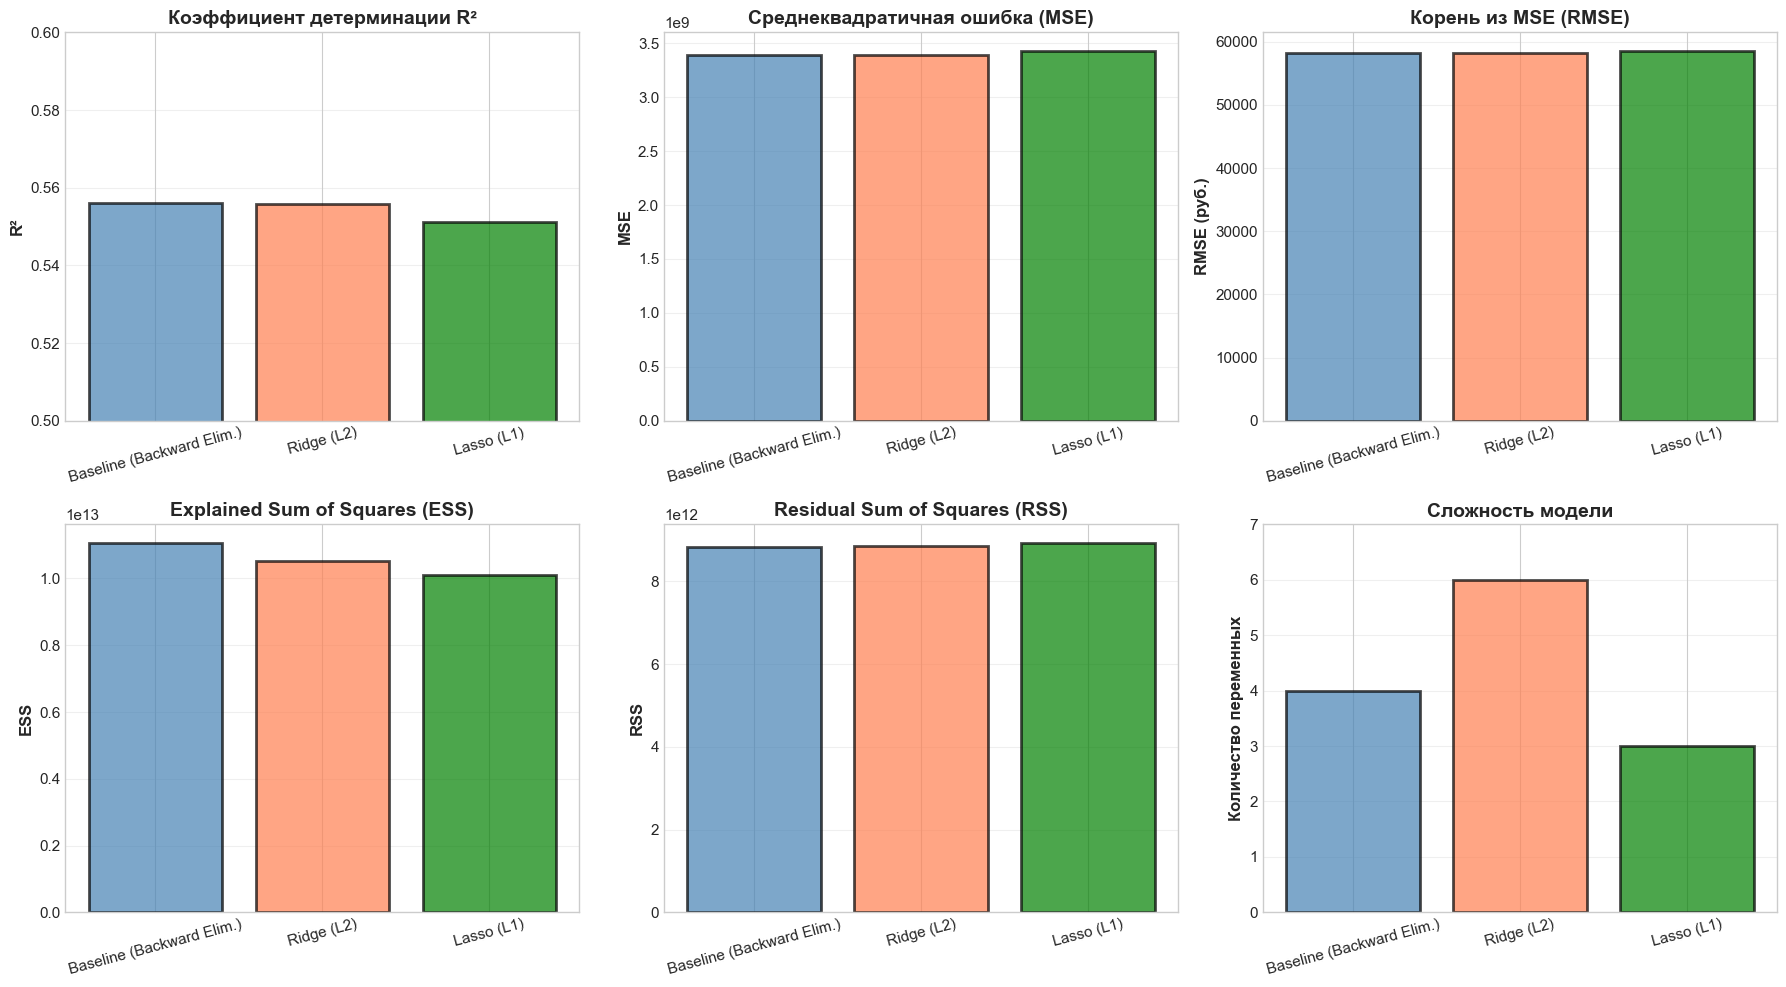


График сравнения сохранен: regularization_comparison.png
Таблица сравнения сохранена: regularization_comparison.csv


In [7]:
# Сводная таблица
comparison = pd.DataFrame({
    'Модель': [
        'Baseline (Backward Elim.)',
        'Ridge (L2)',
        'Lasso (L1)'
    ],
    'R²': [r2_baseline, r2_ridge, r2_lasso],
    'MSE': [mse_baseline, mse_ridge, mse_lasso],
    'RMSE': [rmse_baseline, rmse_ridge, rmse_lasso],
    'ESS': [ess_baseline, ess_ridge, ess_lasso],
    'RSS': [rss_baseline, rss_ridge, rss_lasso],
    'N_vars': [len(best_vars_task3), len(X_all_vars), n_nonzero_lasso]
})

print("\n", comparison.to_string(index=False))

# Визуализация сравнения
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

models = comparison['Модель'].tolist()

# R²
axes[0, 0].bar(models, comparison['R²'], color=['steelblue', 'coral', 'green'], 
               alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 0].set_ylabel('R²', fontweight='bold', fontsize=12)
axes[0, 0].set_title('Коэффициент детерминации R²', fontweight='bold', fontsize=14)
axes[0, 0].set_ylim(0.5, 0.6)
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=15)

# MSE
axes[0, 1].bar(models, comparison['MSE'], color=['steelblue', 'coral', 'green'], 
               alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 1].set_ylabel('MSE', fontweight='bold', fontsize=12)
axes[0, 1].set_title('Среднеквадратичная ошибка (MSE)', fontweight='bold', fontsize=14)
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=15)

# RMSE
axes[0, 2].bar(models, comparison['RMSE'], color=['steelblue', 'coral', 'green'], 
               alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 2].set_ylabel('RMSE (руб.)', fontweight='bold', fontsize=12)
axes[0, 2].set_title('Корень из MSE (RMSE)', fontweight='bold', fontsize=14)
axes[0, 2].grid(axis='y', alpha=0.3)
axes[0, 2].tick_params(axis='x', rotation=15)

# ESS
axes[1, 0].bar(models, comparison['ESS'], color=['steelblue', 'coral', 'green'], 
               alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 0].set_ylabel('ESS', fontweight='bold', fontsize=12)
axes[1, 0].set_title('Explained Sum of Squares (ESS)', fontweight='bold', fontsize=14)
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=15)

# RSS
axes[1, 1].bar(models, comparison['RSS'], color=['steelblue', 'coral', 'green'], 
               alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('RSS', fontweight='bold', fontsize=12)
axes[1, 1].set_title('Residual Sum of Squares (RSS)', fontweight='bold', fontsize=14)
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=15)

# Количество переменных
axes[1, 2].bar(models, comparison['N_vars'], color=['steelblue', 'coral', 'green'], 
               alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 2].set_ylabel('Количество переменных', fontweight='bold', fontsize=12)
axes[1, 2].set_title('Сложность модели', fontweight='bold', fontsize=14)
axes[1, 2].set_ylim(0, 7)
axes[1, 2].grid(axis='y', alpha=0.3)
axes[1, 2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('../results/figures/regularization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nГрафик сравнения сохранен: regularization_comparison.png")

# Сохранение таблицы
comparison.to_csv('../results/tables/regularization_comparison.csv', index=False)
print("Таблица сравнения сохранена: regularization_comparison.csv")

In [ ]:
# 7. АНАЛИЗ ESS (EXPLAINED SUM OF SQUARES)

In [11]:
print("""
ESS показывает, какую часть общей вариации Y модель объясняет.

Формула: ESS = Σ(ŷᵢ - ȳ)²

Чем БОЛЬШЕ ESS, тем лучше модель объясняет данные.
ESS связано с R²: R² = ESS/TSS
""")

print(f"\nСравнение ESS:")
print(f"  TSS (Total Sum of Squares) = {tss:.2f}")
print(f"  Baseline (Backward Elim.): ESS = {ess_baseline:.2f} (R² = {r2_baseline:.6f})")
print(f"  Ridge (L2):                ESS = {ess_ridge:.2f} (R² = {r2_ridge:.6f})")
print(f"  Lasso (L1):                ESS = {ess_lasso:.2f} (R² = {r2_lasso:.6f})")

# Определение лучшей модели по ESS
best_ess_idx = comparison['ESS'].idxmax()
best_model_by_ess = comparison.loc[best_ess_idx, 'Модель']

print(f"\nЛучшая модель по ESS: {best_model_by_ess}")
print(f"  ESS = {comparison.loc[best_ess_idx, 'ESS']:.2f}")


ESS показывает, какую часть общей вариации Y модель объясняет.

Формула: ESS = Σ(ŷᵢ - ȳ)²

Чем БОЛЬШЕ ESS, тем лучше модель объясняет данные.
ESS связано с R²: R² = ESS/TSS


Сравнение ESS:
  TSS (Total Sum of Squares) = 19910246276015.88
  Baseline (Backward Elim.): ESS = 11072096598815.55 (R² = 0.556100)
  Ridge (L2):                ESS = 10526015901363.57 (R² = 0.555900)
  Lasso (L1):                ESS = 10094610271260.26 (R² = 0.551203)

Лучшая модель по ESS: Baseline (Backward Elim.)
  ESS = 11072096598815.55


In [ ]:
# 8. ВЫБОР ЛУЧШЕЙ МОДЕЛИ С РЕГУЛЯРИЗАЦИЕЙ

In [12]:
print("\nКритерии выбора:")
print("  1. R² (объясняющая способность)")
print("  2. MSE/RMSE (точность прогноза)")
print("  3. ESS (объясненная вариация)")
print("  4. Количество переменных (простота)")

# Ранжирование по каждому критерию
comparison['Rank_R2'] = comparison['R²'].rank(ascending=False)
comparison['Rank_MSE'] = comparison['MSE'].rank(ascending=True)  # меньше = лучше
comparison['Rank_ESS'] = comparison['ESS'].rank(ascending=False)
comparison['Rank_Vars'] = comparison['N_vars'].rank(ascending=True)  # меньше = проще

# Средний ранг
comparison['Avg_Rank'] = comparison[['Rank_R2', 'Rank_MSE', 'Rank_ESS', 'Rank_Vars']].mean(axis=1)

print("\nРанжирование моделей:")
print(comparison[['Модель', 'Rank_R2', 'Rank_MSE', 'Rank_ESS', 'Rank_Vars', 'Avg_Rank']].to_string(index=False))

best_model_idx = comparison['Avg_Rank'].idxmin()
best_model_name = comparison.loc[best_model_idx, 'Модель']

print(f"\nЛУЧШАЯ МОДЕЛЬ (по среднему рангу): {best_model_name}")
print(f"  R² = {comparison.loc[best_model_idx, 'R²']:.6f}")
print(f"  MSE = {comparison.loc[best_model_idx, 'MSE']:.2f}")
print(f"  ESS = {comparison.loc[best_model_idx, 'ESS']:.2f}")
print(f"  Переменных = {int(comparison.loc[best_model_idx, 'N_vars'])}")


Критерии выбора:
  1. R² (объясняющая способность)
  2. MSE/RMSE (точность прогноза)
  3. ESS (объясненная вариация)
  4. Количество переменных (простота)

Ранжирование моделей:
                   Модель  Rank_R2  Rank_MSE  Rank_ESS  Rank_Vars  Avg_Rank
Baseline (Backward Elim.)      1.0       1.0       1.0        2.0      1.25
               Ridge (L2)      2.0       2.0       2.0        3.0      2.25
               Lasso (L1)      3.0       3.0       3.0        1.0      2.50

ЛУЧШАЯ МОДЕЛЬ (по среднему рангу): Baseline (Backward Elim.)
  R² = 0.556100
  MSE = 3392763791.63
  ESS = 11072096598815.55
  Переменных = 4


In [ ]:
# 9. ИТОГОВЫЕ ВЫВОДЫ

In [15]:
print(f"""
СРАВНЕНИЕ МОДЕЛЕЙ:

1. Baseline (Backward Elimination) - {len(best_vars_task3)} переменные:
   R² = {r2_baseline:.4f}, MSE = {mse_baseline:.0f}, ESS = {ess_baseline:.0f}
   
2. Ridge (L2) - {len(X_all_vars)} переменных:
   R² = {r2_ridge:.4f}, MSE = {mse_ridge:.0f}, ESS = {ess_ridge:.0f}
   α = {best_alpha_ridge:.4f}
   
3. Lasso (L1) - {n_nonzero_lasso} переменных:
   R² = {r2_lasso:.4f}, MSE = {mse_lasso:.0f}, ESS = {ess_lasso:.0f}
   α = {best_alpha_lasso:.4f}

ВЫБОР ЛУЧШЕЙ МОДЕЛИ: {best_model_name}

КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
  Ridge сохраняет все переменные, но уменьшает их коэффициенты
  Lasso может исключать переменные (обнулять коэффициенты)
  Модель из Задания 3 остается конкурентоспособной
  Регуляризация помогает при большом количестве переменных

РЕКОМЕНДАЦИЯ:
Для данной задачи модель {best_model_name} является оптимальной,
так как обеспечивает лучший баланс между точностью прогноза,
объясняющей способностью и простотой интерпретации.
""")



СРАВНЕНИЕ МОДЕЛЕЙ:

1. Baseline (Backward Elimination) - 4 переменные:
   R² = 0.5561, MSE = 3392763792, ESS = 11072096598816

2. Ridge (L2) - 6 переменных:
   R² = 0.5559, MSE = 3394294900, ESS = 10526015901364
   α = 58.5702

3. Lasso (L1) - 3 переменных:
   R² = 0.5512, MSE = 3430199081, ESS = 10094610271260
   α = 2420.1283

ВЫБОР ЛУЧШЕЙ МОДЕЛИ: Baseline (Backward Elim.)

КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
  Ridge сохраняет все переменные, но уменьшает их коэффициенты
  Lasso может исключать переменные (обнулять коэффициенты)
  Модель из Задания 3 остается конкурентоспособной
  Регуляризация помогает при большом количестве переменных

РЕКОМЕНДАЦИЯ:
Для данной задачи модель Baseline (Backward Elim.) является оптимальной,
так как обеспечивает лучший баланс между точностью прогноза,
объясняющей способностью и простотой интерпретации.

